In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def gen(dtype, d):
    if (dtype == "simple"):
        def logp(x):
            return -0.5 * np.dot(x, x)
        
        def grad_logp(x):
            return -x

        samples = rng.normal(0, 1, size=(1000, d))
        
    elif (dtype == "gaus"):
        means = [np.ones(d) * 2, -np.ones(d) * 2]
        covs = [np.eye(d), np.eye(d) * 0.5]
        weights = [0.6, 0.4]
            
        def logp(x):
            logs = []
            for i in range(len(means)):
                diff = x - means[i]
                log_p = -0.5 * diff @ np.linalg.inv(covs[i]) @ diff
                log_p -= 0.5 * np.log(np.linalg.det(2 * np.pi * covs[i]))
                logs.append(log_p + np.log(weights[i]))
            return np.logaddexp.reduce(logs)
            
        def grad_logp(x):
            eps = 1e-6
            grad = np.zeros(d)
            
            for i in range(d):
                x_plus = x.copy()
                x_minus = x.copy()
                x_plus[i] += eps
                x_minus[i] -= eps
                grad[i] = (logp(x_plus) - logp(x_minus)) / (2 * eps)
            return grad
            
        n_samples = 1000
        components = rng.choice(len(means), size=n_samples, p=weights)
        samples = np.zeros((n_samples, d))
        for i, comp in enumerate(components):
            samples[i] = rng.multivariate_normal(means[comp], covs[comp])
                
    return logp, grad_logp, samples

def logq(x_from, x_to, eta, grad_logp):
    mean = x_to + eta * grad_logp(x_to)
    diff = x_from - mean
    return -0.5 * np.dot(diff, diff) / (2 * eta) - 0.5 * d * np.log(4 * np.pi * eta)

def normal_pdf(x, mean, std):
    return (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)


In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()
    acf_ = np.correlate(x, x, mode='full')
    acf_ = acf_[len(acf_) // 2:]
    
    if acf_[0] != 0 and not np.isnan(acf_[0]):
        acf_ /= acf_[0]
    else:
        acf_[1:] = 0
    
    tau = 1 + 2 * np.sum(acf_[1:200])
    return len(x) / tau

def calc_ess(chain):
    vect = []
    for i in range (chain.shape[1]):
        vect.append(ess(chain[:, i]))
    return np.median(vect)


In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range (steps):
        y = x + step * grad_logp(x) + np.sqrt(2 * step) * rng.normal(0, 1, size=d)

        mean_yx = x + step * grad_logp(x)
        diff_yx = y - mean_yx
        log_q_yx = -0.5 * np.dot(diff_yx, diff_yx) / (2 * step)
        
        mean_xy = y + step * grad_logp(y)
        diff_xy = x - mean_xy
        log_q_xy = -0.5 * np.dot(diff_xy, diff_xy) / (2 * step)
        
        log_pi_y = logp(y)
        log_pi_x = logp(x)
        
        log_a = (log_pi_y - log_pi_x) + (log_q_xy - log_q_yx)
        
        if np.log(rng.uniform()) < min(0, log_a):
            x = y
            accept += 1

        chain[t] = x
        
    return chain, accept / steps

In [6]:
types = ["simple", "gaus"]

mh_chain_sample = None
mala_chain_sample = None

mh_chain_mine = None
mala_chain_mine = None

for t in types:
    d = 10
    steps = 30000
    burn = 5000
    x0 = np.ones(d) * 2

    if (t == "simple"):
        mala_step = 0.5 # тут попробуйте подобрать хороший шаг
        mh_scale = 2.4 / np.sqrt(d) # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?
    else:
        mala_step = 0.5
        mh_scale = 0.67
        
    logp, grad_logp, true_samples = gen(t, d)
    
    mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
    mala_chain, mala_acc = mala(x0, steps, step=mala_step)
    
    # Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
    burn_in = int(steps * 0.5)
    
    mh_chain_burned = mh_chain[burn_in:]
    mala_chain_burned = mala_chain[burn_in:]
    
    mh_ess = calc_ess(mh_chain_burned)
    mala_ess = calc_ess(mala_chain_burned)

    if (t == "simple"):
        print ("Given samples V")
        mh_chain_sample = mh_chain_burned
        mala_chain_sample = mala_chain_burned
    else:
        print ("My samples V")
        mh_chain_mine = mh_chain_burned
        mala_chain_mine = mala_chain_burned
        
    print(f"MH acceptance rate: {mh_acc:.5f}")
    print(f"MH median ESS: {mh_ess:.5f}\n")
    
    print(f"MALA acceptance rate: {mala_acc:.5f}")
    print(f"MALA median ESS: {mala_ess:.5f}\n")

# print(mh_chain.shape)

Given samples V
MH acceptance rate: 0.25450
MH median ESS: 566.65545

MALA acceptance rate: 0.69587
MALA median ESS: 4584.52791

My samples V
MH acceptance rate: 0.31143
MH median ESS: 547.55151

MALA acceptance rate: 0.70123
MALA median ESS: 4191.25302



In [7]:
import matplotlib.pyplot as plt

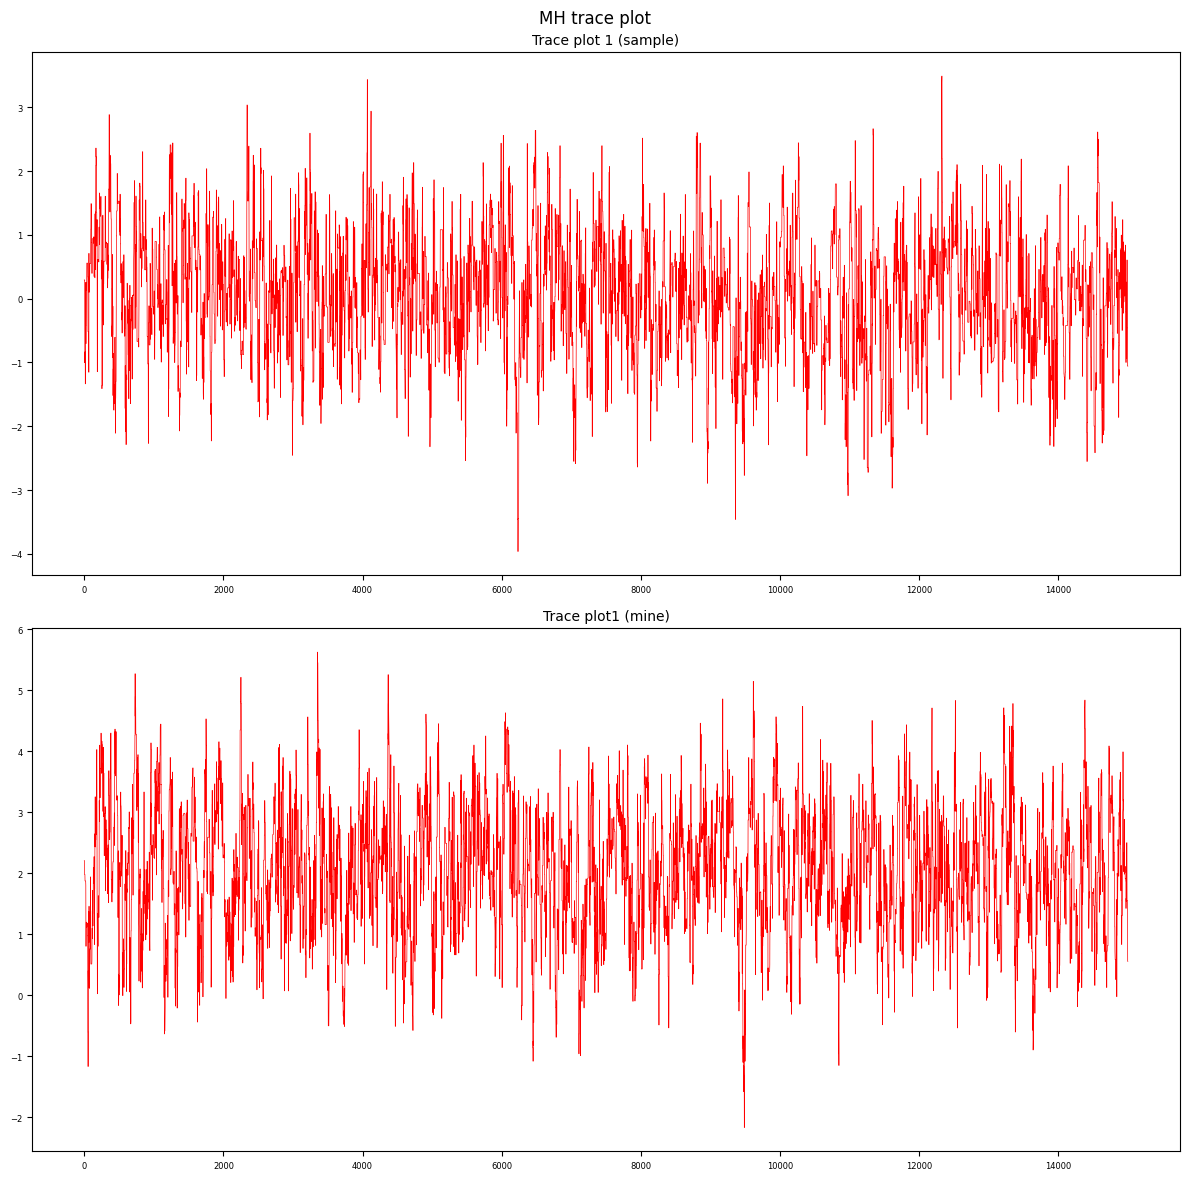

In [8]:
# trace plot (значение цепи vs итерация)

i = 0 # возьмем 1-ое измерение

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(mh_chain_sample[:, i], 'r', linewidth=0.5)
ax[0].tick_params(axis='both', labelsize = 6)
ax[0].set_title(f"Trace plot {i + 1} (sample)", fontsize = 10)

ax[1].plot(mh_chain_mine[:, i], 'r', linewidth=0.5)
ax[1].tick_params(axis='both', labelsize = 6)
ax[1].set_title(f"Trace plot{i + 1} (mine)", fontsize = 10)

#plt.xlabel("Iteration (n)", fontsize=3)
#plt.ylabel("X^n", fontsize=3)

plt.suptitle("MH trace plot")
plt.tight_layout()
plt.show()

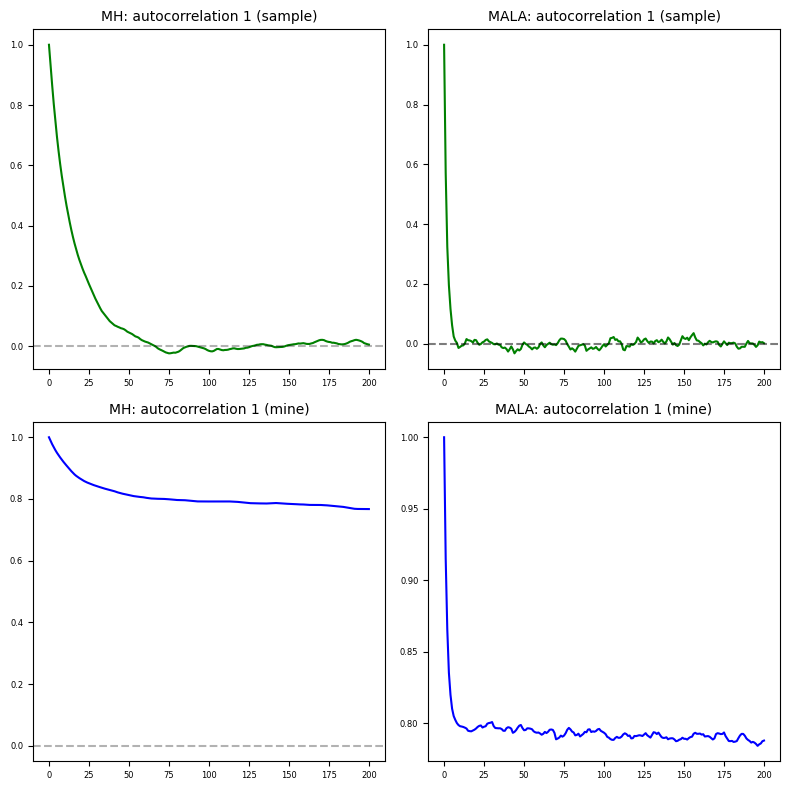

In [9]:
# график автокорреляции (значение ACF vs задержка по времени) 

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
lag = 200 # максимальный

i = 0 # опять-таки посмотрим первое измерение

x1 = mh_chain_sample[:, i]
acf1 = np.correlate(x1, x1, mode='full')
acf1 = acf1[len(acf1) // 2 : len(acf1) // 2 + lag + 1]
acf1 /= acf1[0]

ax[0][0].plot(range(len(acf1)), acf1, color='g')
ax[0][0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax[0][0].tick_params(axis='both', labelsize = 6)
ax[0][0].set_title(f"MH: autocorrelation {i + 1} (sample)", fontsize = 10)


x2 = mala_chain_sample[:, i]
acf2 = np.correlate(x2, x2, mode='full')
acf2 = acf2[len(acf2) // 2 : len(acf2) // 2 + lag + 1]
acf2 /= acf2[0]

ax[0][1].plot(range(len(acf2)), acf2, color='g')
ax[0][1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax[0][1].tick_params(axis='both', labelsize = 6)
ax[0][1].set_title(f"MALA: autocorrelation {i + 1} (sample)", fontsize = 10)

x1 = mh_chain_mine[:, i]
acf1 = np.correlate(x1, x1, mode='full')
acf1 = acf1[len(acf1) // 2 : len(acf1) // 2 + lag + 1]
acf1 /= acf1[0]

ax[1][0].plot(range(len(acf1)), acf1, color='b')
ax[1][0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax[1][0].tick_params(axis='both', labelsize = 6)
ax[1][0].set_title(f"MH: autocorrelation {i + 1} (mine)", fontsize = 10)


x2 = mala_chain_mine[:, i]
acf2 = np.correlate(x2, x2, mode='full')
acf2 = acf2[len(acf2) // 2 : len(acf2) // 2 + lag + 1]
acf2 /= acf2[0]

ax[1][1].plot(range(len(acf2)), acf2, color='b')
ax[0][1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax[1][1].tick_params(axis='both', labelsize = 6)
ax[1][1].set_title(f"MALA: autocorrelation {i + 1} (mine)", fontsize = 10)


plt.tight_layout()
plt.show()

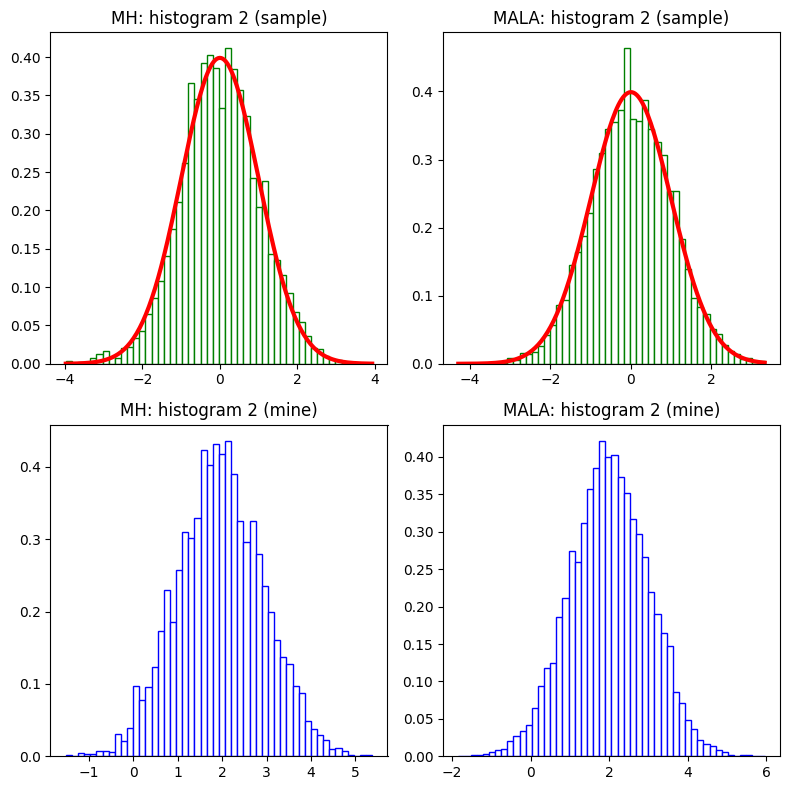

In [10]:
# гистограмма семплов (возьмите какую-то одну размерность)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

i = 1 # номер любого куска

# нормальная
sample1 = mh_chain_sample[:, i]
ax[0][0].hist(sample1, bins=50, density=True, alpha=1, edgecolor='g', color='w')
ax[0][0].set_title(f'MH: histogram {i + 1} (sample)', fontsize=12)

x_range1 = np.linspace(sample1.min(), sample1.max(), 200)
t_pdf1 = normal_pdf(x_range1, 0, 1)
ax[0][0].plot(x_range1, t_pdf1, 'r', linewidth=3)

sample1 = mala_chain_sample[:, i]
ax[0][1].hist(sample1, bins=50, density=True, alpha=1, edgecolor='g', color='w')
ax[0][1].set_title(f'MALA: histogram {i + 1} (sample)', fontsize=12)

x_range1 = np.linspace(sample1.min(), sample1.max(), 200)
t_pdf1 = normal_pdf(x_range1, 0, 1)
ax[0][1].plot(x_range1, t_pdf1, 'r', linewidth=3)

# смесь гауссиан
means = [np.ones(d) * 2, -np.ones(d) * 2]
covs = [np.eye(d), np.eye(d) * 0.5]
weights = [0.6, 0.4]

sample2 = mh_chain_mine[:, i]
ax[1][0].hist(sample2, bins=50, density=True, alpha=1, edgecolor='b', color='w')
ax[1][0].set_title(f'MH: histogram {i + 1} (mine)', fontsize=12)

sample2 = mala_chain_mine[:, i]
ax[1][1].hist(sample2, bins=50, density=True, alpha=1, edgecolor='b', color='w')
ax[1][1].set_title(f'MALA: histogram {i + 1} (mine)', fontsize=12)


plt.tight_layout()
plt.show()

**Вывод:** На примере двух сэмпов можно заметить, что на первом сете (N(0, I)) лучше использовать MALA, в то время как на втором - смесь гауссиан - MH. 
В предложенном нормальном распределении лучше использовать MALA, так как мы имеем дело с одномодальным распределением (по графику видно, что и описывает оно его лучше).  Второй сет, а именно выбранная мной смесь имеет разделенные моды, поэтому предпочтительнее использовать MH.